<a href="https://colab.research.google.com/github/RayirthSoni/Aspect-Based-Sentiment-Analysis-for-Product-Reviews/blob/main/ABSA_for_Product_Reviews_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Mounted at /content/drive


# All Downloads

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00


# Importing Files from Directory

In [ ]:
!cp /content/drive/MyDrive/SNA\ Project/stop_words.py /content
!cp /content/drive/MyDrive/SNA\ Project/wn_affect.py /content

cp: cannot stat '/content/drive/MyDrive/SNA Project/stop_words.py': No such file or directory
cp: cannot stat '/content/drive/MyDrive/SNA Project/wn_affect.py': No such file or directory


# Importing all libraries

In [ ]:
import json
import pandas as pd
import numpy as np
import os
import re
import sys
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, precision_score, recall_score
import collections
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from stop_words import stop_words_list
from wn_affect import wn_affect
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import gzip
import pickle
import tensorflow as tf
tf.test.gpu_device_name()
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


ModuleNotFoundError: ignored

# File Names

In [ ]:
# All Paths

# Dataset path
dataset_path = r"/content/drive/MyDrive/SNA Project/Dataset/cell_phones_and_accessories.json"

# Saved DataFrame
df_path = r"/content/drive/MyDrive/SNA Project/Dataset/processed_dataframe.json"

# LDA Model for document

# lda model for identifying topics
lda_topic_path = r"/content/drive/MyDrive/SNA Project/Models"

# LDA Model for devices
lda_device_path = r"/content/drive/MyDrive/SNA Project/Models"


# Wordcloud and Graphs for devices
# image for devices
img_device_path = r"/content/drive/MyDrive/SNA Project/Images"

# Get Dataframe

In [ ]:
sample_df = pd.read_json(dataset_path,lines=True)
sample_df

NameError: ignored

In [ ]:
df_original = sample_df.copy()
df_original.columns
# remove unnecessary columns
df_original.drop(['reviewerID','asin','reviewerName','helpful','overall','unixReviewTime','reviewTime'],inplace=True,axis=1)
df_original

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

reviewText  \
0       They look good and stick good! I just don't li...   
1       These stickers work like the review says they ...   
2       These are awesome and make my phone look so st...   
3       Item arrived in great time and was in perfect ...   
4       awesome! stays on, and looks great. can be use...   
...                                                   ...   
194434  Works great just like my original one. I reall...   
194435  Great product. Great packaging. High quality a...   
194436  This is a great cable, just as good as the mor...   
194437  I really like it becasue it works well with my...   
194438  product as described, I have wasted a lot of m...   

                                                  summary  
0                                              Looks Good  
1                                   Really great product.  
2                                          LOVE LOVE LOVE  
3                                                   Cute!  
4               leopard home button sticker for iphone 4s  
...                                                   ...  
194434                           This works just perfect!  
194435           Great replacement cable. Apple certified  
194436                                       Real quality  
194437  I really like it becasue it works well with my...  
194438              I have wasted a lot of money on cords  

[194439 rows x 2 columns]

## Preprocessing

In [ ]:
# cast text as lowercase, remove punctuation, remove extra whitespace in string and on both sides of string
def preprocessing(review):
    review = review.lower()
    review = re.sub(r"'",'',review)
    review = re.sub('[^\w\s]',' ',review)
    review = re.sub(" \d+", " ",review)
    review = re.sub(" +",' ',review)
    review = review.strip()
    return review

In [ ]:
# apply sentiment analysis
analyser = SentimentIntensityAnalyzer()
def get_sentiment_and_score(preprocessed_review):
    sent_score = None
    sent_label = None
    sentiment_score = analyser.polarity_scores(preprocessed_review)
    if sentiment_score['compound'] >= 0.05:
        sent_score = sentiment_score['compound']
        sent_label = 'Positive'
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sent_score = sentiment_score['compound']
        sent_label = 'Neutral'
    elif sentiment_score['compound'] <= -0.05:
        sent_score = sentiment_score['compound']
        sent_label = 'Negative'
    return sent_label,sent_score

In [ ]:
def get_sentiment_summary(preprocessed_review):
    sent_label = None
    sentiment_score = analyser.polarity_scores(preprocessed_review)
    if sentiment_score['compound'] >= 0.05:
        sent_label = 'Positive'
    elif sentiment_score['compound'] > -0.05 and sentiment_score['compound'] < 0.05:
        sent_label = 'Neutral'
    elif sentiment_score['compound'] <= -0.05:
        sent_label = 'Negative'
    return sent_label

In [ ]:
# Preprocess the review
df_original['preprocessed review'] = df_original['reviewText'].apply(preprocessing)
df_original['preprocessed summary'] = df_original['summary'].apply(preprocessing)
df_original.head()

reviewText  \
0  They look good and stick good! I just don't li...   
1  These stickers work like the review says they ...   
2  These are awesome and make my phone look so st...   
3  Item arrived in great time and was in perfect ...   
4  awesome! stays on, and looks great. can be use...   

                                     summary  \
0                                 Looks Good   
1                      Really great product.   
2                             LOVE LOVE LOVE   
3                                      Cute!   
4  leopard home button sticker for iphone 4s   

                                 preprocessed review  \
0  they look good and stick good i just dont like...   
1  these stickers work like the review says they ...   
2  these are awesome and make my phone look so st...   
3  item arrived in great time and was in perfect ...   
4  awesome stays on and looks great can be used o...   

                       preprocessed summary  
0                                looks good  
1                      really great product  
2                            love love love  
3                                      cute  
4  leopard home button sticker for iphone s

## tokenise

In [ ]:
# tokenise prepreprocesed review
df_original['tokenise'] = df_original.apply(lambda x: nltk.word_tokenize(x["preprocessed review"]), axis=1)
df_original.head()

reviewText  \
0  They look good and stick good! I just don't li...   
1  These stickers work like the review says they ...   
2  These are awesome and make my phone look so st...   
3  Item arrived in great time and was in perfect ...   
4  awesome! stays on, and looks great. can be use...   

                                     summary  \
0                                 Looks Good   
1                      Really great product.   
2                             LOVE LOVE LOVE   
3                                      Cute!   
4  leopard home button sticker for iphone 4s   

                                 preprocessed review  \
0  they look good and stick good i just dont like...   
1  these stickers work like the review says they ...   
2  these are awesome and make my phone look so st...   
3  item arrived in great time and was in perfect ...   
4  awesome stays on and looks great can be used o...   

                       preprocessed summary  \
0                                looks good   
1                      really great product   
2                            love love love   
3                                      cute   
4  leopard home button sticker for iphone s   

                                            tokenise  
0  [they, look, good, and, stick, good, i, just, ...  
1  [these, stickers, work, like, the, review, say...  
2  [these, are, awesome, and, make, my, phone, lo...  
3  [item, arrived, in, great, time, and, was, in,...  
4  [awesome, stays, on, and, looks, great, can, b...

In [ ]:
# Get Sentiment anf Sentiment Score for Reviews
df_original[['sentiment','sentiment score']] = df_original['preprocessed review'].apply(get_sentiment_and_score).apply(pd.Series)
df_original['summary sentiment'] = df_original['preprocessed summary'].apply(get_sentiment_summary).apply(pd.Series)
df_original.head()

reviewText  \
0  They look good and stick good! I just don't li...   
1  These stickers work like the review says they ...   
2  These are awesome and make my phone look so st...   
3  Item arrived in great time and was in perfect ...   
4  awesome! stays on, and looks great. can be use...   

                                     summary  \
0                                 Looks Good   
1                      Really great product.   
2                             LOVE LOVE LOVE   
3                                      Cute!   
4  leopard home button sticker for iphone 4s   

                                 preprocessed review  \
0  they look good and stick good i just dont like...   
1  these stickers work like the review says they ...   
2  these are awesome and make my phone look so st...   
3  item arrived in great time and was in perfect ...   
4  awesome stays on and looks great can be used o...   

                       preprocessed summary  \
0                                looks good   
1                      really great product   
2                            love love love   
3                                      cute   
4  leopard home button sticker for iphone s   

                                            tokenise sentiment  \
0  [they, look, good, and, stick, good, i, just, ...  Positive   
1  [these, stickers, work, like, the, review, say...  Positive   
2  [these, are, awesome, and, make, my, phone, lo...  Positive   
3  [item, arrived, in, great, time, and, was, in,...  Positive   
4  [awesome, stays, on, and, looks, great, can, b...  Positive   

   sentiment score summary sentiment  
0           0.4922          Positive  
1           0.9136          Positive  
2           0.8481          Positive  
3           0.9584          Positive  
4           0.8957           Neutral

## remove stopwords

In [ ]:
# initiate stopwords from nltk
stop_words = stopwords.words('english')

# add additional missing terms
stop_words.extend(stop_words_list)

# remove stopwords
df_original['remove_stopwords'] = df_original['tokenise'].apply(lambda x: [item for item in x if item not in stop_words])

df_original.head()

reviewText  \
0  They look good and stick good! I just don't li...   
1  These stickers work like the review says they ...   
2  These are awesome and make my phone look so st...   
3  Item arrived in great time and was in perfect ...   
4  awesome! stays on, and looks great. can be use...   

                                     summary  \
0                                 Looks Good   
1                      Really great product.   
2                             LOVE LOVE LOVE   
3                                      Cute!   
4  leopard home button sticker for iphone 4s   

                                 preprocessed review  \
0  they look good and stick good i just dont like...   
1  these stickers work like the review says they ...   
2  these are awesome and make my phone look so st...   
3  item arrived in great time and was in perfect ...   
4  awesome stays on and looks great can be used o...   

                       preprocessed summary  \
0                                looks good   
1                      really great product   
2                            love love love   
3                                      cute   
4  leopard home button sticker for iphone s   

                                            tokenise sentiment  \
0  [they, look, good, and, stick, good, i, just, ...  Positive   
1  [these, stickers, work, like, the, review, say...  Positive   
2  [these, are, awesome, and, make, my, phone, lo...  Positive   
3  [item, arrived, in, great, time, and, was, in,...  Positive   
4  [awesome, stays, on, and, looks, great, can, b...  Positive   

   sentiment score summary sentiment  \
0           0.4922          Positive   
1           0.9136          Positive   
2           0.8481          Positive   
3           0.9584          Positive   
4           0.8957           Neutral   

                                    remove_stopwords  
0  [good, stick, good, rounded, shape, bumping, s...  
1  [stickers, work, review, stick, stay, phone, s...  
2     [awesome, phone, stylish, year, year, quality]  
3  [item, arrived, time, perfect, condition, orde...  
4  [awesome, stays, multiple, apple, products, na...

## lemmatise

In [ ]:
# initiate nltk lemmatiser
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatise words
df_original['lemmatise'] = df_original['remove_stopwords'].apply(lambda x: [wordnet_lemmatizer.lemmatize(y) for y in x]) 

df_original.head()

reviewText  \
0  They look good and stick good! I just don't li...   
1  These stickers work like the review says they ...   
2  These are awesome and make my phone look so st...   
3  Item arrived in great time and was in perfect ...   
4  awesome! stays on, and looks great. can be use...   

                                     summary  \
0                                 Looks Good   
1                      Really great product.   
2                             LOVE LOVE LOVE   
3                                      Cute!   
4  leopard home button sticker for iphone 4s   

                                 preprocessed review  \
0  they look good and stick good i just dont like...   
1  these stickers work like the review says they ...   
2  these are awesome and make my phone look so st...   
3  item arrived in great time and was in perfect ...   
4  awesome stays on and looks great can be used o...   

                       preprocessed summary  \
0                                looks good   
1                      really great product   
2                            love love love   
3                                      cute   
4  leopard home button sticker for iphone s   

                                            tokenise sentiment  \
0  [they, look, good, and, stick, good, i, just, ...  Positive   
1  [these, stickers, work, like, the, review, say...  Positive   
2  [these, are, awesome, and, make, my, phone, lo...  Positive   
3  [item, arrived, in, great, time, and, was, in,...  Positive   
4  [awesome, stays, on, and, looks, great, can, b...  Positive   

   sentiment score summary sentiment  \
0           0.4922          Positive   
1           0.9136          Positive   
2           0.8481          Positive   
3           0.9584          Positive   
4           0.8957           Neutral   

                                    remove_stopwords  \
0  [good, stick, good, rounded, shape, bumping, s...   
1  [stickers, work, review, stick, stay, phone, s...   
2     [awesome, phone, stylish, year, year, quality]   
3  [item, arrived, time, perfect, condition, orde...   
4  [awesome, stays, multiple, apple, products, na...   

                                           lemmatise  
0  [good, stick, good, rounded, shape, bumping, s...  
1  [sticker, work, review, stick, stay, phone, su...  
2     [awesome, phone, stylish, year, year, quality]  
3  [item, arrived, time, perfect, condition, orde...  
4  [awesome, stay, multiple, apple, product, nail...

## save dataframe

In [ ]:
df_original.to_json(df_path)

## load dataframe

In [ ]:
df_original = pd.read_json(df_path)
df_original

reviewText  \
0       They look good and stick good! I just don't li...   
1       These stickers work like the review says they ...   
2       These are awesome and make my phone look so st...   
3       Item arrived in great time and was in perfect ...   
4       awesome! stays on, and looks great. can be use...   
...                                                   ...   
194434  Works great just like my original one. I reall...   
194435  Great product. Great packaging. High quality a...   
194436  This is a great cable, just as good as the mor...   
194437  I really like it becasue it works well with my...   
194438  product as described, I have wasted a lot of m...   

                                                  summary  \
0                                              Looks Good   
1                                   Really great product.   
2                                          LOVE LOVE LOVE   
3                                                   Cute!   
4               leopard home button sticker for iphone 4s   
...                                                   ...   
194434                           This works just perfect!   
194435           Great replacement cable. Apple certified   
194436                                       Real quality   
194437  I really like it becasue it works well with my...   
194438              I have wasted a lot of money on cords   

                                      preprocessed review  \
0       they look good and stick good i just dont like...   
1       these stickers work like the review says they ...   
2       these are awesome and make my phone look so st...   
3       item arrived in great time and was in perfect ...   
4       awesome stays on and looks great can be used o...   
...                                                   ...   
194434  works great just like my original one i really...   
194435  great product great packaging high quality and...   
194436  this is a great cable just as good as the more...   
194437  i really like it becasue it works well with my...   
194438  product as described i have wasted a lot of mo...   

                                     preprocessed summary  \
0                                              looks good   
1                                    really great product   
2                                          love love love   
3                                                    cute   
4                leopard home button sticker for iphone s   
...                                                   ...   
194434                            this works just perfect   
194435            great replacement cable apple certified   
194436                                       real quality   
194437  i really like it becasue it works well with my...   
194438              i have wasted a lot of money on cords   

                                                 tokenise sentiment  \
0       [they, look, good, and, stick, good, i, just, ...  Positive   
1       [these, stickers, work, like, the, review, say...  Positive   
2       [these, are, awesome, and, make, my, phone, lo...  Positive   
3       [item, arrived, in, great, time, and, was, in,...  Positive   
4       [awesome, stays, on, and, looks, great, can, b...  Positive   
...                                                   ...       ...   
194434  [works, great, just, like, my, original, one, ...  Positive   
194435  [great, product, great, packaging, high, quali...  Positive   
194436  [this, is, a, great, cable, just, as, good, as...  Positive   
194437  [i, really, like, it, becasue, it, works, well...  Positive   
194438  [product, as, described, i, have, wasted, a, l...  Positive   

        sentiment score summary sentiment  \
0                0.4922          Positive   
1                0.9136          Positive   
2                0.8481          Positive   
3                0.9584          Positive   
4                0.8957           Neu

# LDA Model for Identifying Topics

In [ ]:
# Function for saving model, variable for another runtime
def save_work(path,model_var,device):
    temp = os.path.join(path,device)
    if not os.path.exists(temp):
        with open(temp,'wb') as f:
            pickle.dump(model_var,f)
        return True
    else:
        return False

In [ ]:
# Function for loading model, variable for another runtime
def load_work(path,device):
    temp = os.path.join(path,device)
    if os.path.exists(temp):
        with open(temp, 'rb') as f:
            model_var = pickle.load(f)
        return model_var
    else:
        return False

In [ ]:
# initialise the count vectorizer
vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2, 2))
print(vectorizer)
print(vectorizer.dtype)
                            
# join the processed data to be vectorised
vectors = []

for index, row in df_original.iterrows():
    vectors.append(", ".join(row['lemmatise']))

vectorised = vectorizer.fit_transform(vectors)

print(vectorised)
print(vectorised.dtype)

CountVectorizer(ngram_range=(2, 2))
<class 'numpy.int64'>
  (0, 723168)	1
  (0, 1631906)	1
  (0, 722755)	1
  (0, 1446046)	1
  (0, 1509740)	1
  (0, 210768)	1
  (0, 1539762)	1
  (0, 1262593)	1
  (0, 884560)	1
  (0, 218683)	1
  (1, 1633449)	1
  (1, 1895513)	1
  (1, 1429993)	1
  (1, 1632496)	1
  (1, 1627410)	1
  (1, 1218556)	1
  (1, 1667247)	1
  (1, 1656357)	1
  (1, 1511030)	1
  (2, 103160)	1
  (2, 1218480)	1
  (2, 1656493)	1
  (2, 1917605)	1
  (2, 1916904)	1
  (3, 889176)	1
  :	:
  (194437, 1315151)	1
  (194437, 250693)	1
  (194437, 952053)	1
  (194437, 133773)	1
  (194438, 1894784)	1
  (194438, 282091)	1
  (194438, 1892389)	1
  (194438, 1250038)	1
  (194438, 1306221)	1
  (194438, 987867)	1
  (194438, 1439441)	1
  (194438, 888620)	1
  (194438, 939917)	1
  (194438, 1217919)	1
  (194438, 1778965)	1
  (194438, 381579)	1
  (194438, 382346)	1
  (194438, 1540299)	1
  (194438, 1212422)	1
  (194438, 485376)	1
  (194438, 382410)	1
  (194438, 1856973)	1
  (194438, 1063474)	1
  (194438, 218859)	1
  

In [ ]:
# lda_model = LatentDirichletAllocation(n_components = 5, random_state = 10, evaluate_every = -1, n_jobs = -1)
lda_model = LatentDirichletAllocation(n_components = 5, evaluate_every = -1, n_jobs = -1)
lda_output = lda_model.fit_transform(vectorised)

In [ ]:
# Prinitng all topic names
keywords = np.array(vectorizer.get_feature_names_out())

topic_keywords = []

for topic_weights in lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:25]
    topic_keywords.append(keywords.take(top_keyword_locs))

for i in topic_keywords:
    print(i)

['battery life' 'charge phone' 'phone case' 'battery pack' 'micro usb'
 'battery phone' 'extended battery' 'bluetooth headset' 'sound quality'
 'phone call' 'phone battery' 'usb cable' 'cell phone' 'battery charger'
 'phone phone' 'charge battery' 'usb port' 'fully charged'
 'samsung galaxy' 'phone charge' 'car charger' 'oem battery' 'iphone case'
 'case case' 'case fit']
['samsung galaxy' 'micro usb' 'cell phone' 'usb port' 'usb cable'
 'charge phone' 'fit phone' 'fit perfectly' 'galaxy s3' 'phone case'
 'galaxy s4' 'car charger' 'case phone' 'battery pack' 'sound quality'
 'battery life' 'charge device' 'case fit' 'highly recommend' 'long time'
 'wall charger' 'good product' 'external battery' 'charging cable'
 'phone time']
['sound quality' 'cell phone' 'phone case' 'battery pack' 'battery life'
 'charge phone' 'case fit' 'hold phone' 'case phone' 'sim card'
 'high quality' 'bluetooth headset' 'usb cable' 'usb port' 'good quality'
 'phone call' 'customer service' 'pretty good' 'micr

## save lda model and output

In [ ]:
save_work(lda_topic_path,vectorizer,device = "lda_topics_vectorizer")
save_work(lda_topic_path,vectorised,device = "lda_topics_vectorised")
save_work(lda_topic_path,lda_model,device = "lda_topics")
save_work(lda_topic_path,lda_output,device = "lda_output")

True

True

True

True

## load lda model and output

In [ ]:
vectorizer = load_work(lda_topic_path,device= "lda_topics_vectorizer")
vectorised = load_work(lda_topic_path,device= "lda_topics_vectorised")
lda_model = load_work(lda_topic_path,device= "lda_topics")
lda_output = load_work(lda_topic_path,device= "lda_output")

# Topics using LDA

In [ ]:
topics = ["galaxy note","galaxy s3","iPad","iPhone"]

# LDA Model for Identifying Aspects of Topics Identified Before

## get lda model for aspects

In [ ]:
def get_LDA_Model(device_name,df_device):

    num_min,num_max = 1,1
    vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (num_min, num_max))
    
    # join the processed data to be vectorised
    vectors = []
    for index, row in df_device.iterrows():
        vectors.append(", ".join(row['lemmatise']))

    vectorised = vectorizer.fit_transform(vectors)

    # lda model
    num_components = 5
    lda_model = LatentDirichletAllocation(n_components = num_components, evaluate_every = 10, n_jobs = -1)

    # lda output
    lda_output = lda_model.fit_transform(vectorised)
    return vectorizer,vectorised,lda_model,lda_output

## get probablity for aspects for every review and dominant one

In [ ]:
# DataFrame used is device dataframe,lda for device,
def get_lda_aspects(df_device,lda_model,lda_output):
    # column names
    aspect_name = ["Aspect" + str(i) for i in range(1, lda_model.n_components + 1)]

    # make the pandas dataframe
    df_doc_aspect = pd.DataFrame(np.round(lda_output, 2), columns = aspect_name)

    # get dominant topic for each document
    dominant_topic = (np.argmax(df_doc_aspect.values, axis=1)+1)
    df_doc_aspect['Dominant_aspect'] = dominant_topic

    # join to original dataframes
    df_device = pd.merge(df_device, df_doc_aspect, left_index = True, right_index = True, how = 'inner')
    
    return df_device

## get aspect score

In [ ]:
def get_lda_aspects_scores(df_device,lda_model,vectorizer,lda_output):
    # index names
    # get all docs for all rows
    docnames = ['Doc' + str(i) for i in range(len(lda_output))]

    # column names
    aspect_names = ["Aspect" + str(i) for i in range(1, lda_model.n_components + 1)]
    # Make the pandas dataframe for all docs and their aspects scrores
    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=aspect_names, index=docnames)

    # Get dominant aspect for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['Dominant_aspect'] = dominant_topic

    # Topic-Keyword Matrix
    df_topic_keywords = pd.DataFrame(lda_model.components_)

    # Assign Column and Index
    df_topic_keywords.columns = vectorizer.get_feature_names_out()
    df_topic_keywords.index = aspect_names

    df_topic_no = pd.DataFrame(df_topic_keywords.idxmax())
    df_scores = pd.DataFrame(df_topic_keywords.max())

    tmp = pd.merge(df_topic_no, df_scores, left_index=True, right_index=True)
    tmp.columns = ['aspect', 'relevance_score']
    tmp['aspect'] = tmp['aspect'].apply(lambda x : x.split('t')[1])

    return tmp

In [ ]:
def get_dominant_topic(tmp):
    tmp_1 = tmp.sort_values('relevance_score', ascending=False).head(1).reset_index()
    return list(tmp_1['index'].unique())

def get_dominant_topics(tmp):
    all_aspects = []
    all_aspects = tmp.groupby('aspect').apply(get_dominant_topic).reset_index(name='aspect_name')
    all_aspects = all_aspects.rename(columns={'aspect': 'Dominant_aspect'})
    return all_aspects

In [ ]:
def analyse_results(df,all_topics):

    results = df.groupby(['Dominant_aspect', 'sentiment']).count().reset_index()

    all_topics['Dominant_aspect'] = results['Dominant_aspect'].astype(int)

    results = results.merge(all_topics, on='Dominant_aspect',how="right")
    results['aspect_name'] = results['aspect_name'].apply(', '.join)

    graph_res = results[['aspect_name', 'sentiment', 'sentiment score']]
    graph_res = graph_res.pivot(index='aspect_name', columns='sentiment', values='sentiment score').reset_index()

    graph_res.set_index('aspect_name', inplace=True)
    ###
    graph_img = graph_res.copy()
    graph_img['Total'] = graph_img.sum(axis=1)
    graph_img['positive percent'] = graph_img['Positive']/graph_img['Total'] * 100 
    graph_img['negative percent'] = graph_img['Negative']/graph_img['Total'] * 100 
    graph_img['neutral percent'] = graph_img['Neutral']/graph_img['Total'] * 100
    graph_img.drop(['Positive','Negative','Neutral','Total'],inplace = True,axis=1)
    # graph_img = graph_res[['positive percent','negative percent','neutral percent']]
    ###
    return graph_res,graph_img

In [ ]:
def show_and_save_plot(df,image_path,device):
    
    # update image_path
    image_path = os.path.join(image_path,device)

    # Create a bar plot of the DataFrame
    fig = df.plot.bar(rot=90, figsize=(8,8))
    
    plt.legend(bbox_to_anchor = (1,1))

    # Save the plot as an image with the specified image_path
    fig.figure.savefig(image_path, bbox_inches='tight')

    # Show the plot
    plt.show()

# Wordnet

In [ ]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # return None
        return wordnet.NOUN

In [ ]:
def get_sentiment_words(df,aspect_num):
    positive_words = []
    negative_words = []

    # dataframe for dominant aspect
    tmp_1 = df.loc[df['Dominant_aspect'] == aspect_num]
    # print(tmp_1)

    # loop through each tokenized text
    for text in tmp_1['tokenise'].values.tolist():
        # loop through each token and its POS tag
        for p in nltk.pos_tag(text):
            get_pos_tag = get_wordnet_pos(p[1])
            if isinstance(get_pos_tag,str):
                try:
                    # get the sentiment scores for the word
                    synset = swn.senti_synset(p[0] + '.' + get_pos_tag +'.01')
                    # check if word is affective and has a sentiment score above threshold
                    if synset.obj_score() <= 0.49:
                        if synset.pos_score() > synset.neg_score() and p[0] in wn_affect:
                                positive_words.append(p[0])
                        elif synset.neg_score() > synset.pos_score() and p[0] in wn_affect:
                                negative_words.append(p[0])     
                except Exception as e:
                    pass
    
    unique_positive_words,unique_negative_words = list(set(positive_words)),list(set(negative_words))
    return positive_words,negative_words,unique_positive_words,unique_negative_words

In [ ]:
def count_words_scores(positive_words,negative_words,unique_positive_words,unique_negative_words):
    count_positive_words = []
    count_negative_words = []

    for i in unique_positive_words:
        counter = [i, positive_words.count(i)]
        count_positive_words.append(counter)

    for i in unique_negative_words:
        counter = [i, negative_words.count(i)]
        count_negative_words.append(counter)    
        
    positive_words = pd.DataFrame(count_positive_words, columns = ['word', 'score'])
    negative_words = pd.DataFrame(count_negative_words, columns = ['word', 'score'])

    positive_words.sort_values('score', ascending=False, inplace = True)
    negative_words.sort_values('score', ascending=False, inplace = True)

    return positive_words, negative_words

In [ ]:
def save_wordcloud(words,image_path):

    word_dict = {}
    for k, v in words.values:
        word_dict[k] = v

    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=word_dict)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(image_path)
    plt.show()

# Aspect Based Sentiment Analysis for Each Topic

## copy of original dataframe

In [ ]:
df = df_original.copy()
df

reviewText  \
0       They look good and stick good! I just don't li...   
1       These stickers work like the review says they ...   
2       These are awesome and make my phone look so st...   
3       Item arrived in great time and was in perfect ...   
4       awesome! stays on, and looks great. can be use...   
...                                                   ...   
194434  Works great just like my original one. I reall...   
194435  Great product. Great packaging. High quality a...   
194436  This is a great cable, just as good as the mor...   
194437  I really like it becasue it works well with my...   
194438  product as described, I have wasted a lot of m...   

                                                  summary  \
0                                              Looks Good   
1                                   Really great product.   
2                                          LOVE LOVE LOVE   
3                                                   Cute!   
4               leopard home button sticker for iphone 4s   
...                                                   ...   
194434                           This works just perfect!   
194435           Great replacement cable. Apple certified   
194436                                       Real quality   
194437  I really like it becasue it works well with my...   
194438              I have wasted a lot of money on cords   

                                      preprocessed review  \
0       they look good and stick good i just dont like...   
1       these stickers work like the review says they ...   
2       these are awesome and make my phone look so st...   
3       item arrived in great time and was in perfect ...   
4       awesome stays on and looks great can be used o...   
...                                                   ...   
194434  works great just like my original one i really...   
194435  great product great packaging high quality and...   
194436  this is a great cable just as good as the more...   
194437  i really like it becasue it works well with my...   
194438  product as described i have wasted a lot of mo...   

                                     preprocessed summary  \
0                                              looks good   
1                                    really great product   
2                                          love love love   
3                                                    cute   
4                leopard home button sticker for iphone s   
...                                                   ...   
194434                            this works just perfect   
194435            great replacement cable apple certified   
194436                                       real quality   
194437  i really like it becasue it works well with my...   
194438              i have wasted a lot of money on cords   

                                                 tokenise sentiment  \
0       [they, look, good, and, stick, good, i, just, ...  Positive   
1       [these, stickers, work, like, the, review, say...  Positive   
2       [these, are, awesome, and, make, my, phone, lo...  Positive   
3       [item, arrived, in, great, time, and, was, in,...  Positive   
4       [awesome, stays, on, and, looks, great, can, b...  Positive   
...                                                   ...       ...   
194434  [works, great, just, like, my, original, one, ...  Positive   
194435  [great, product, great, packaging, high, quali...  Positive   
194436  [this, is, a, great, cable, just, as, good, as...  Positive   
194437  [i, really, like, it, becasue, it, works, well...  Positive   
194438  [product, as, described, i, have, wasted, a, l...  Positive   

        sentiment score summary sentiment  \
0                0.4922          Positive   
1                0.9136          Positive   
2                0.8481          Positive   
3                0.9584          Positive   
4                0.8957           Neu

## ABSA for all topics

galaxy s3


<ipython-input-32-9c5e267fce95>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_device.drop('index',axis=1,inplace=True)


Dominant_aspect  aspect_name
0               1    [android]
1               2     [charge]
2               3    [battery]
3               4       [case]
4               5  [bluetooth]

sentiment    positive percent  negative percent  neutral percent
aspect_name                                                     
android              87.50000          9.659091         2.840909
battery              87.50000          9.659091         2.840909
bluetooth            85.37931         11.862069         2.758621
case                 85.37931         11.862069         2.758621
charge               87.50000          9.659091         2.840909

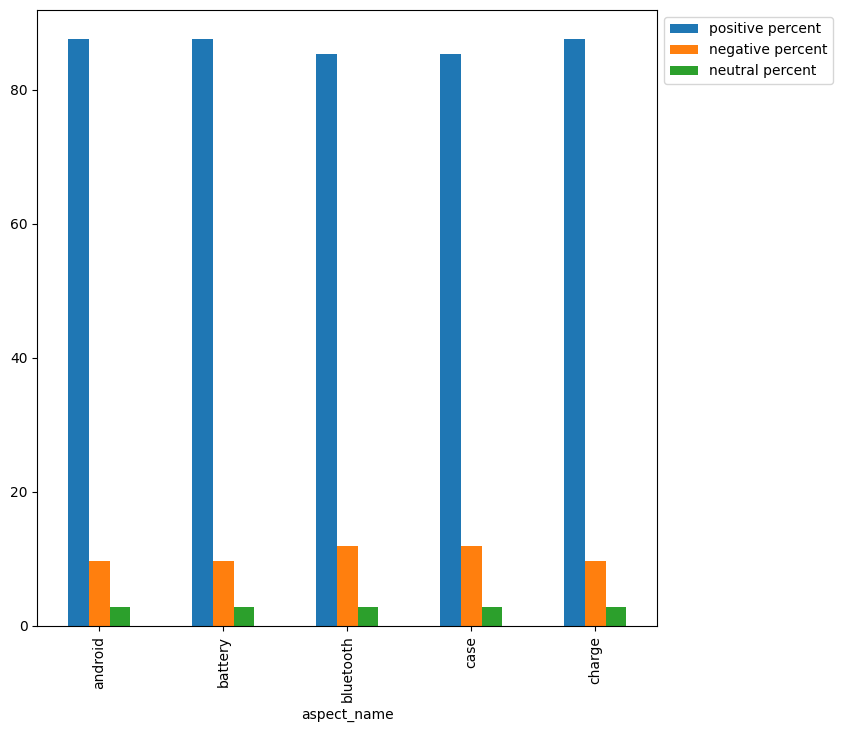

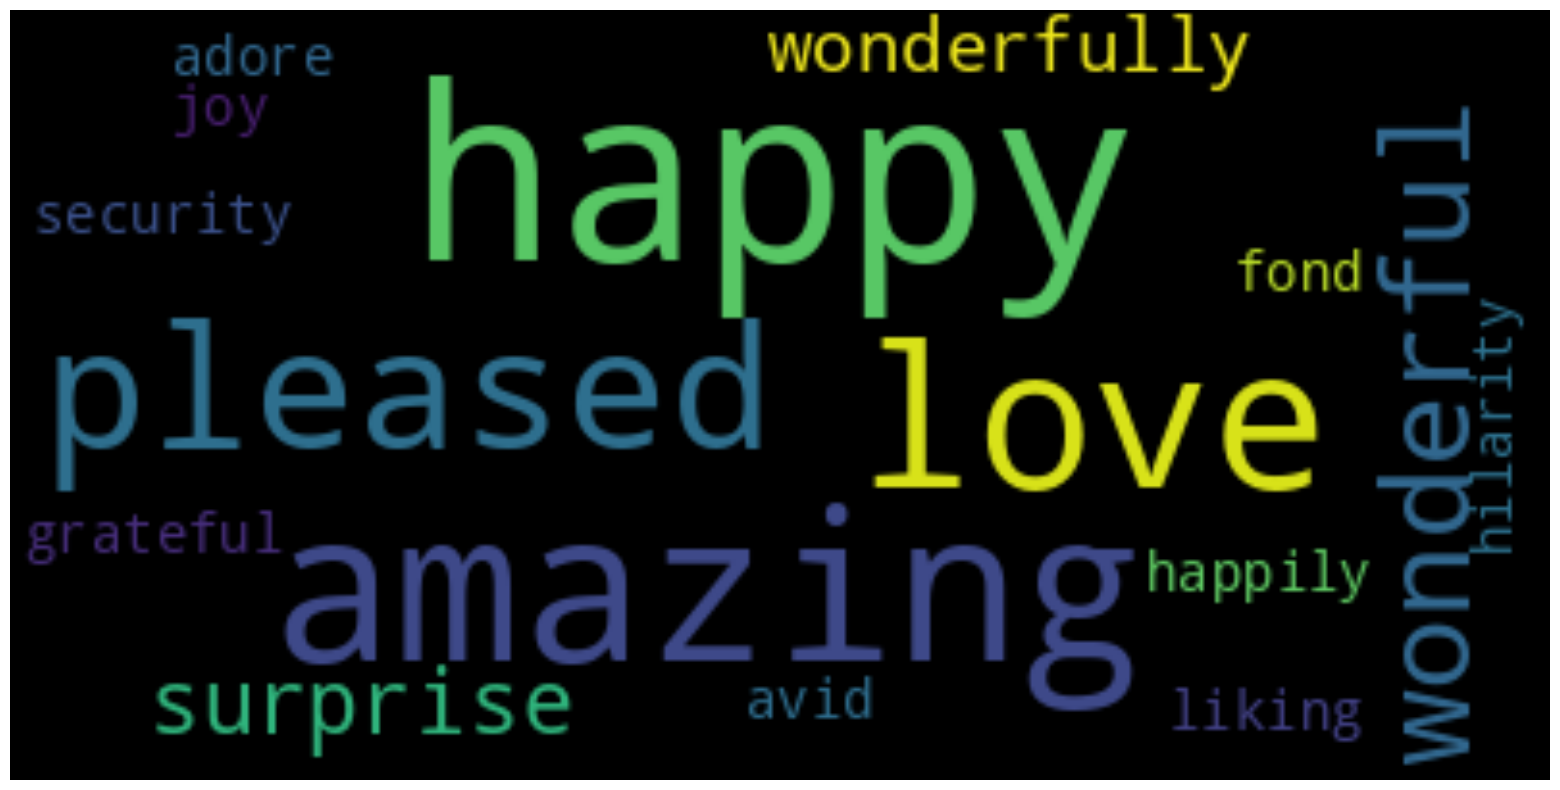

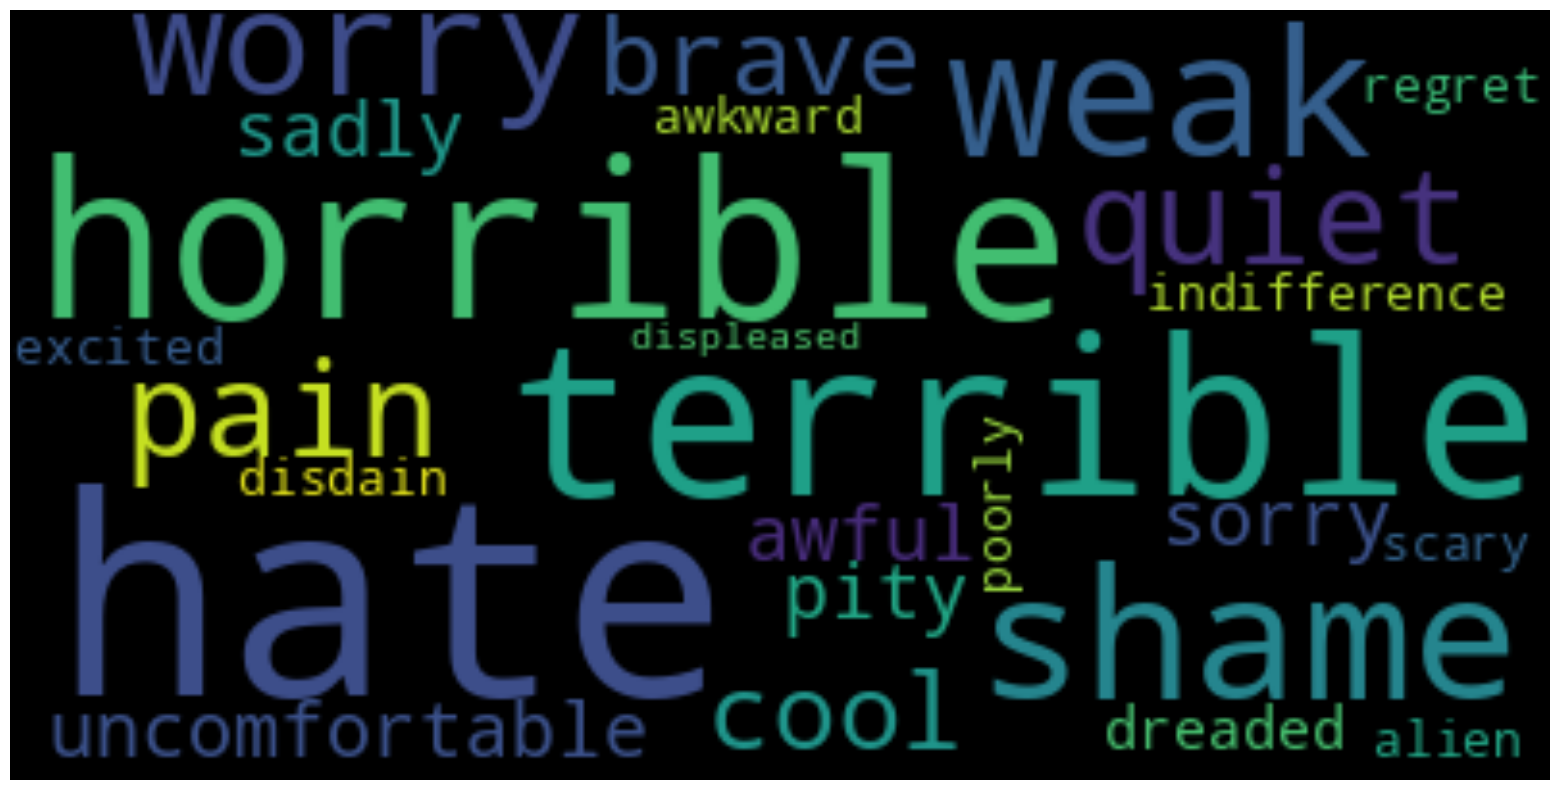

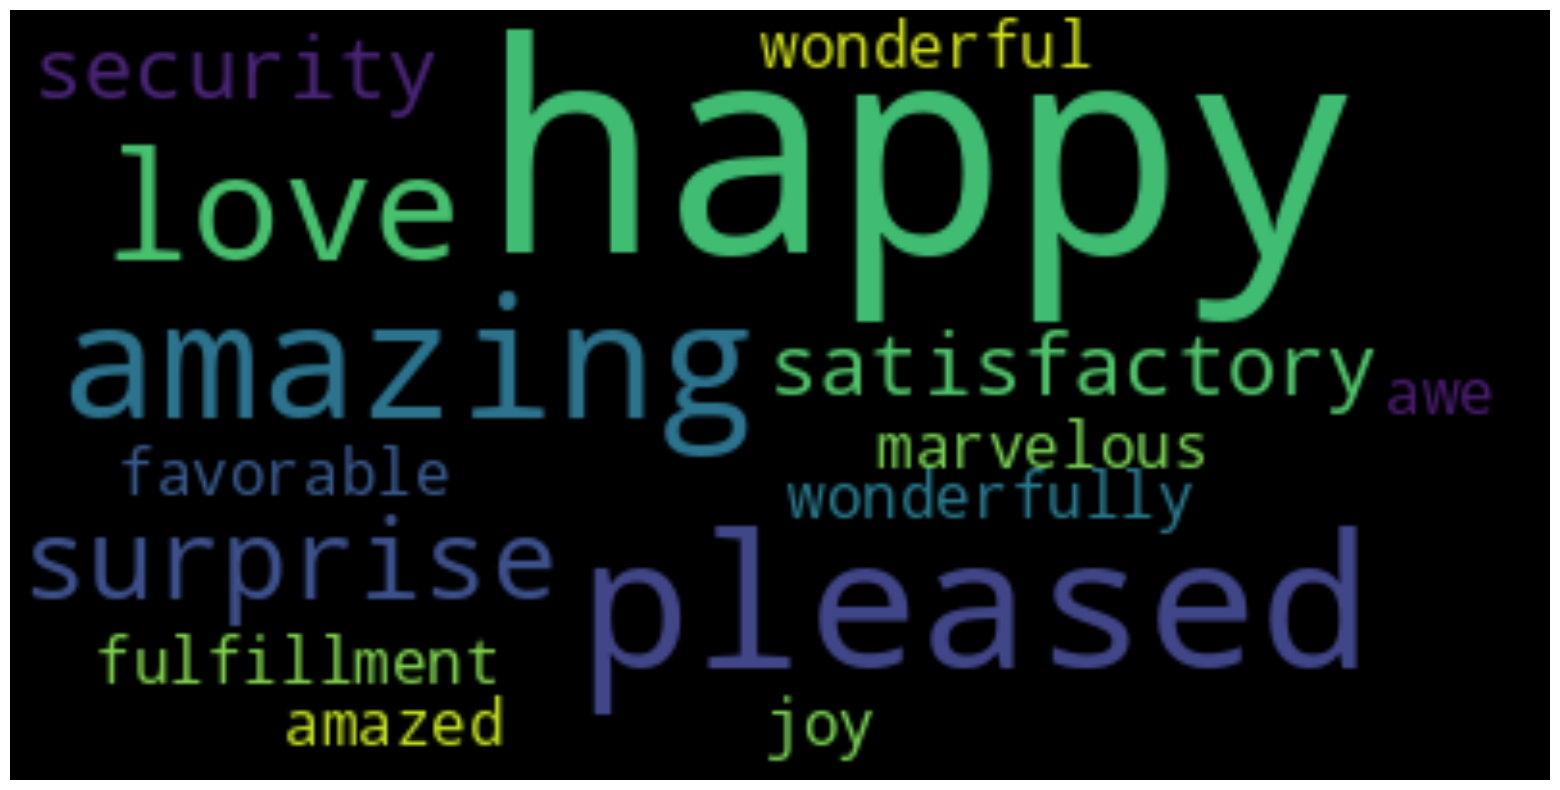

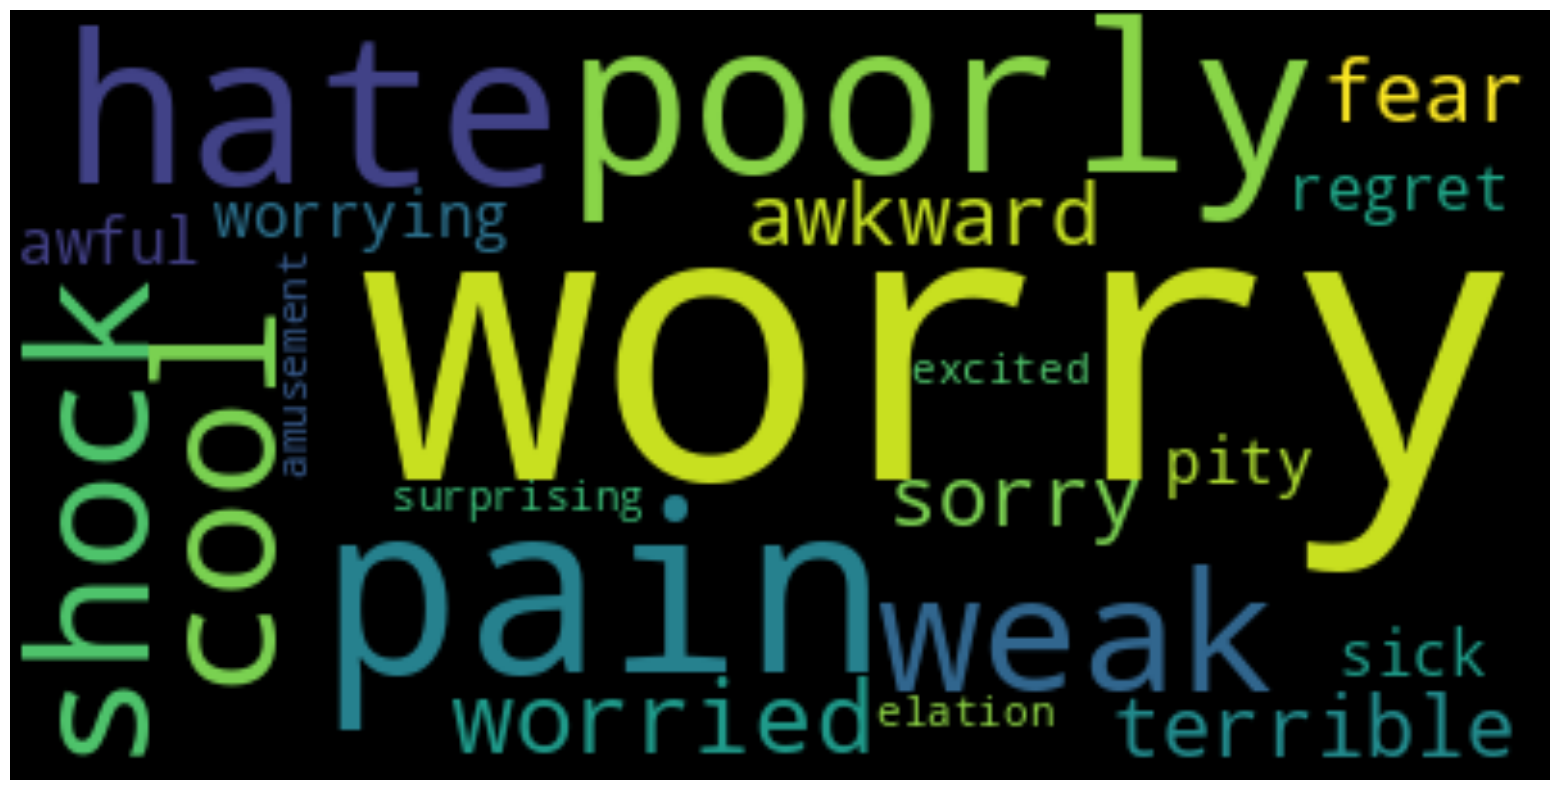

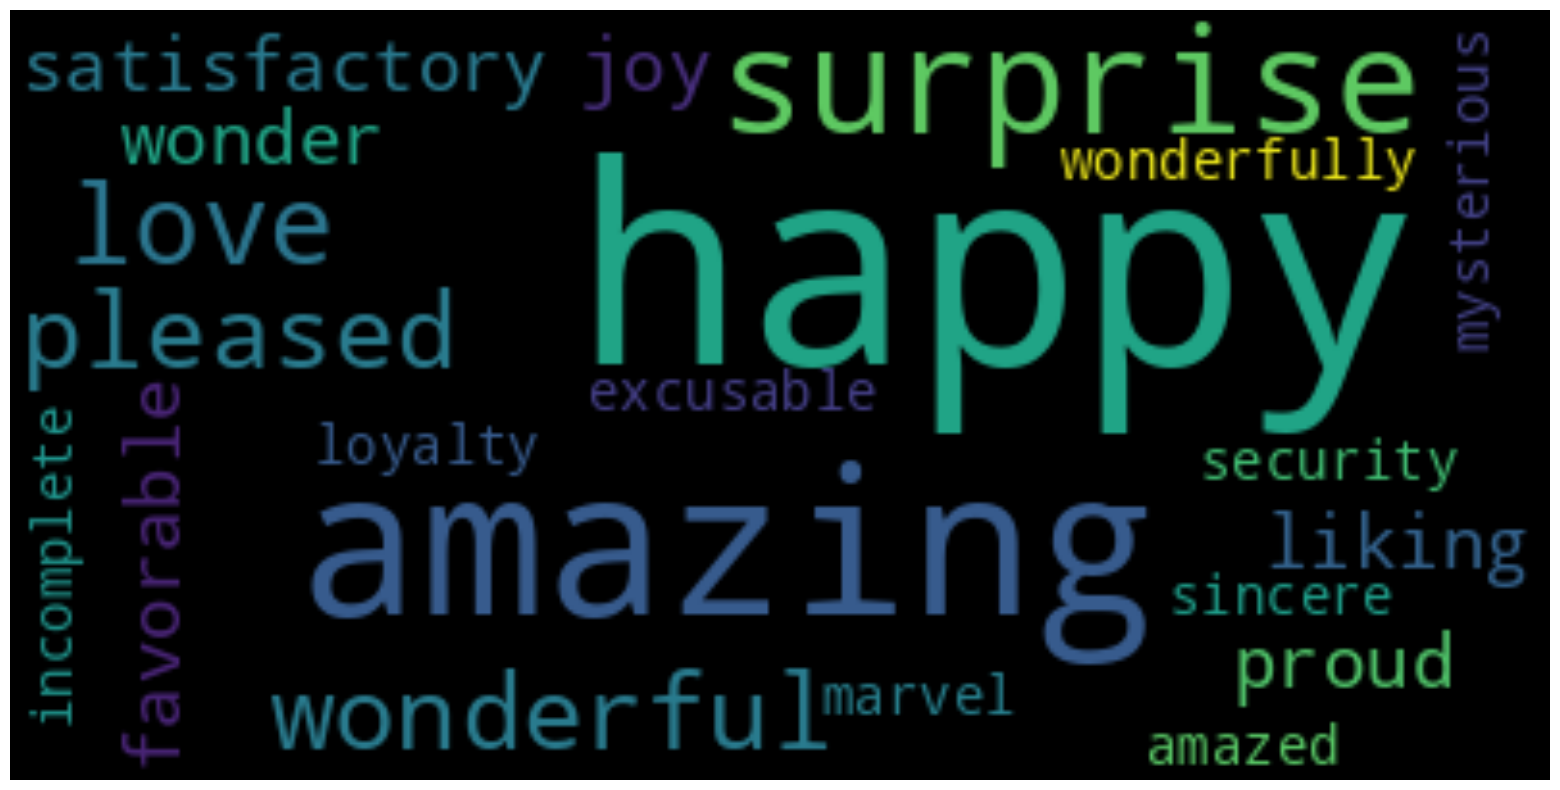

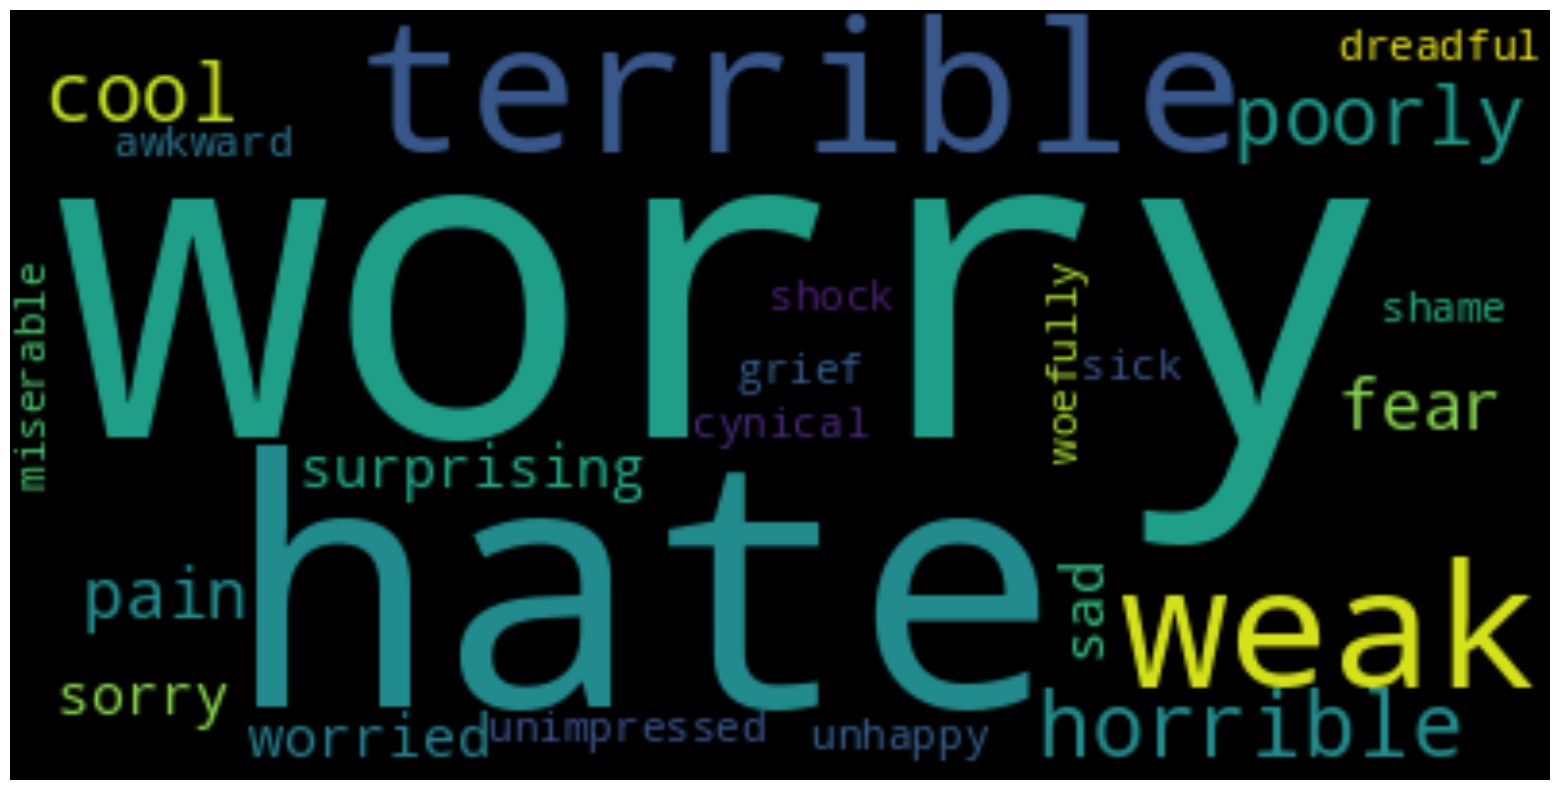

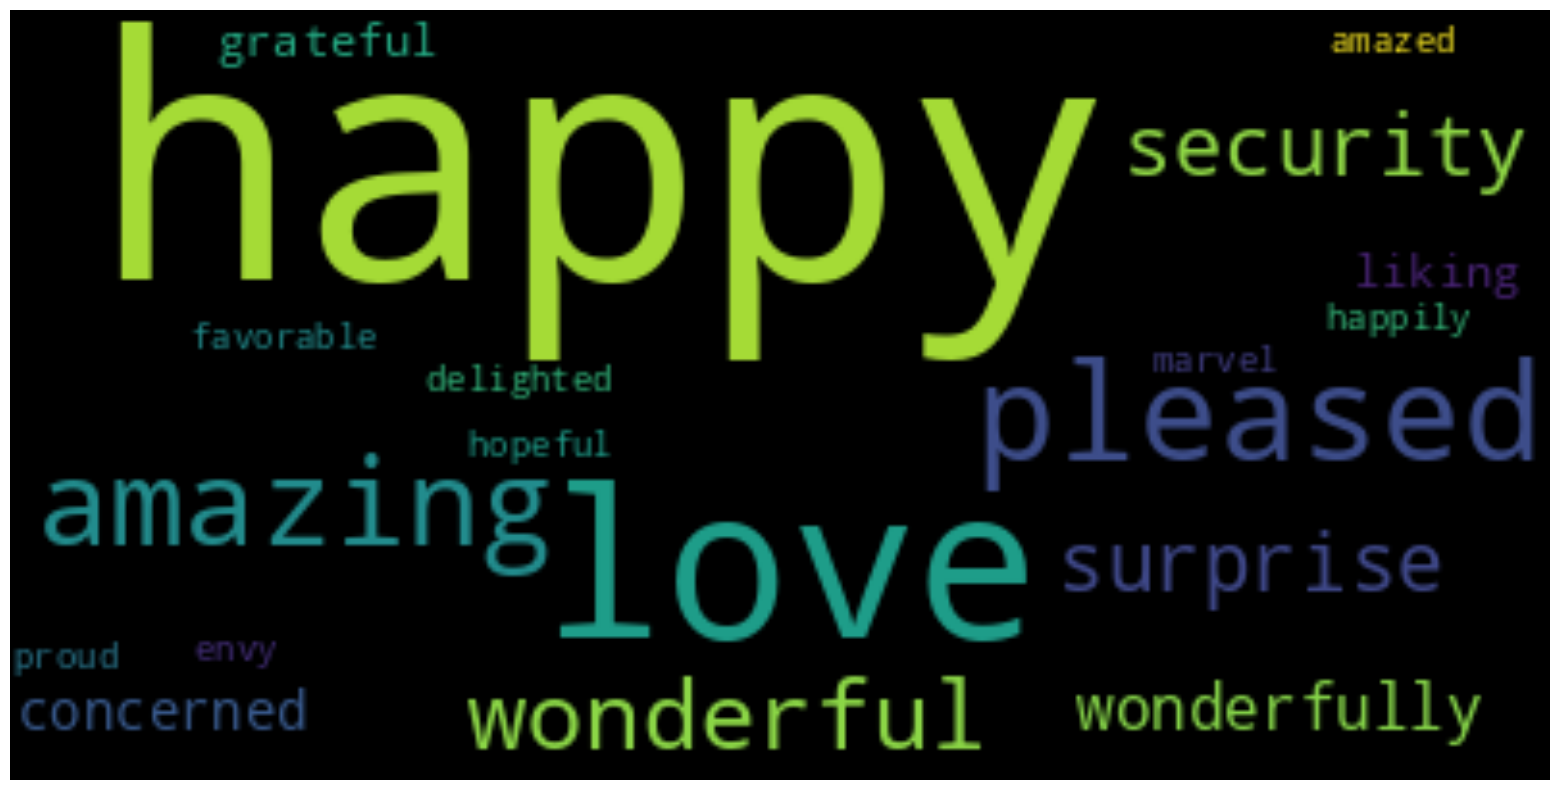

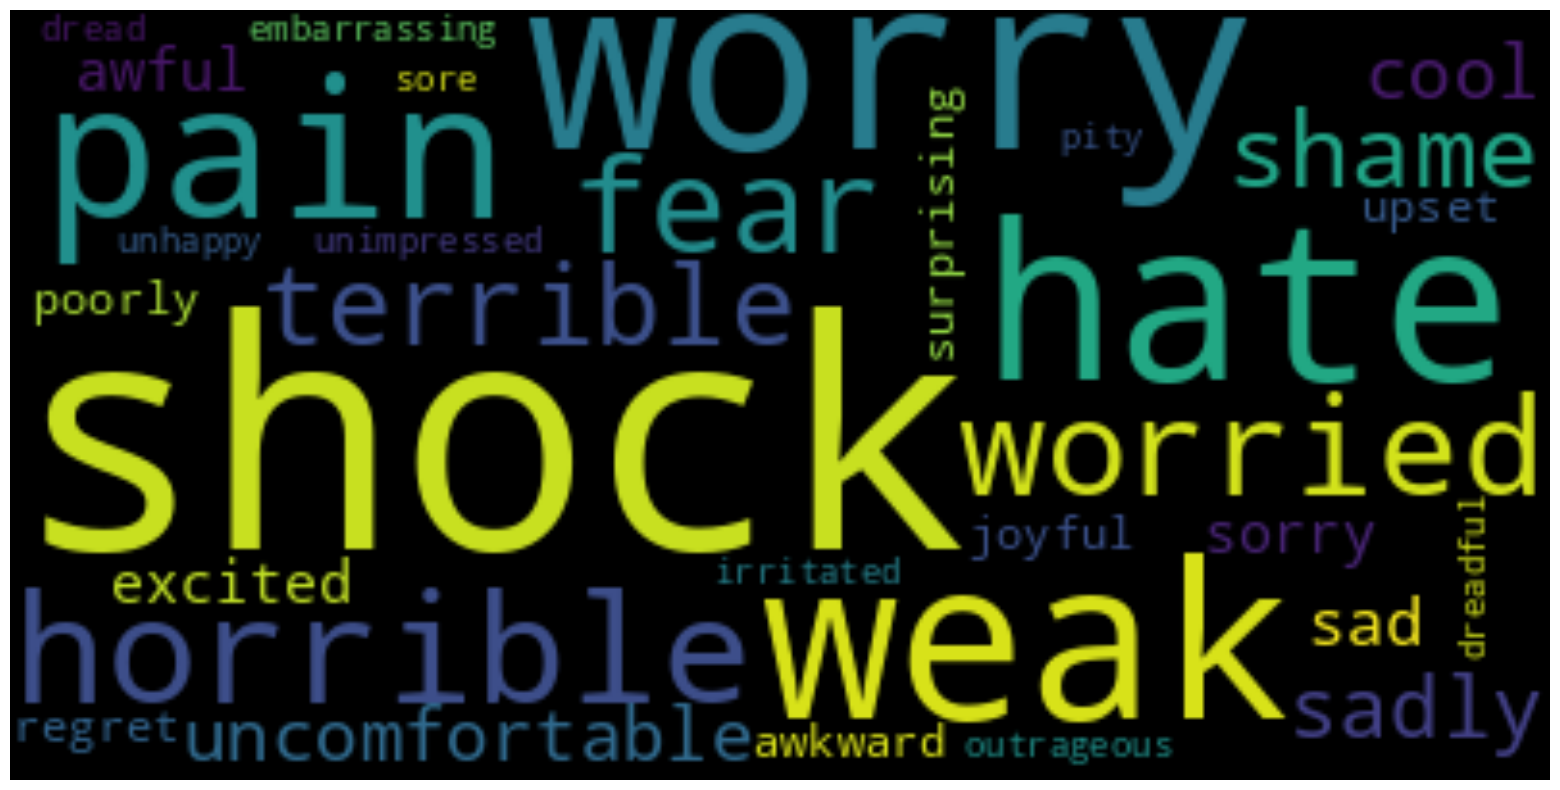

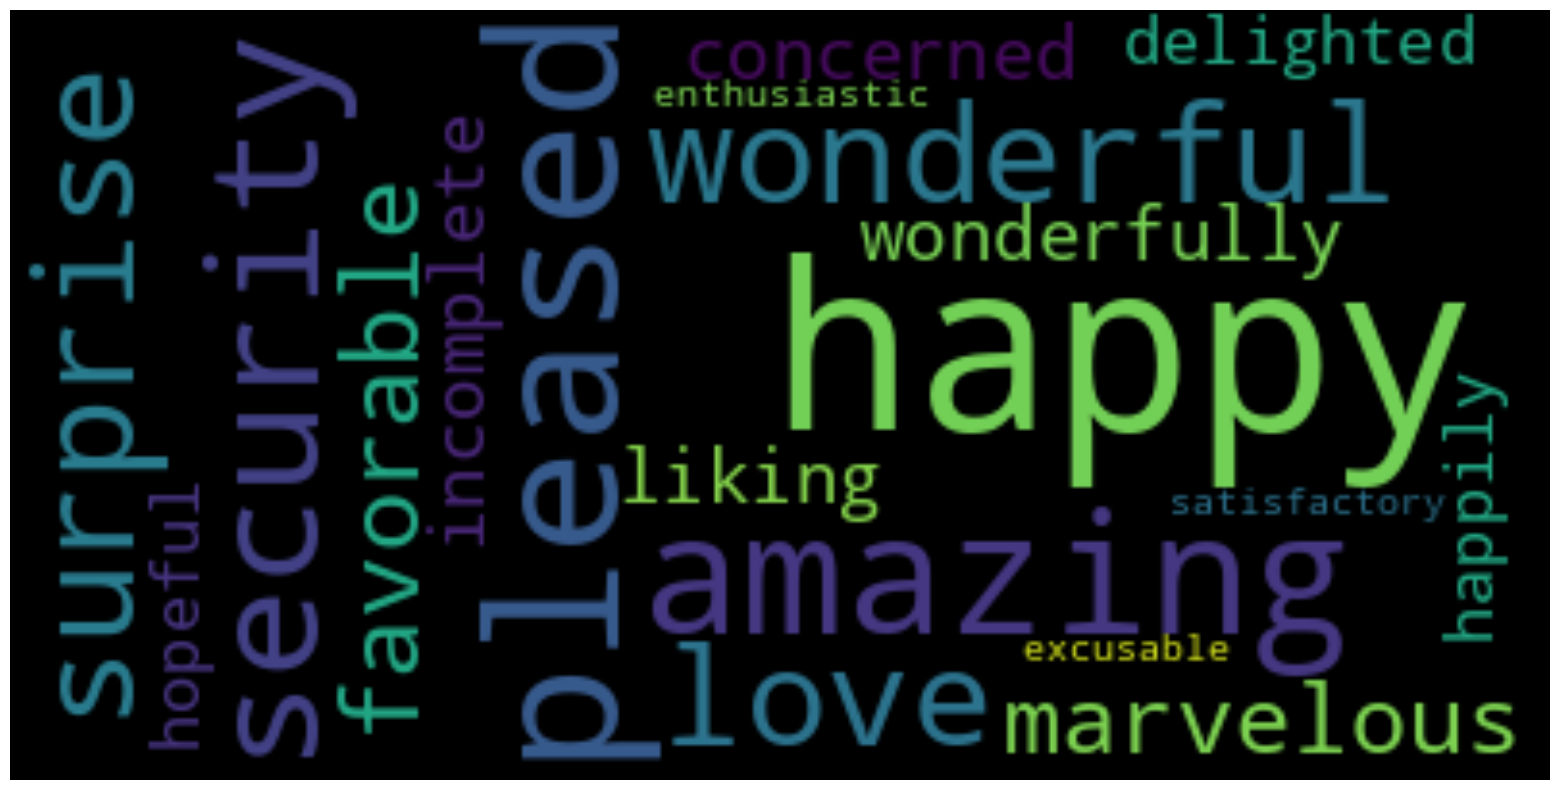

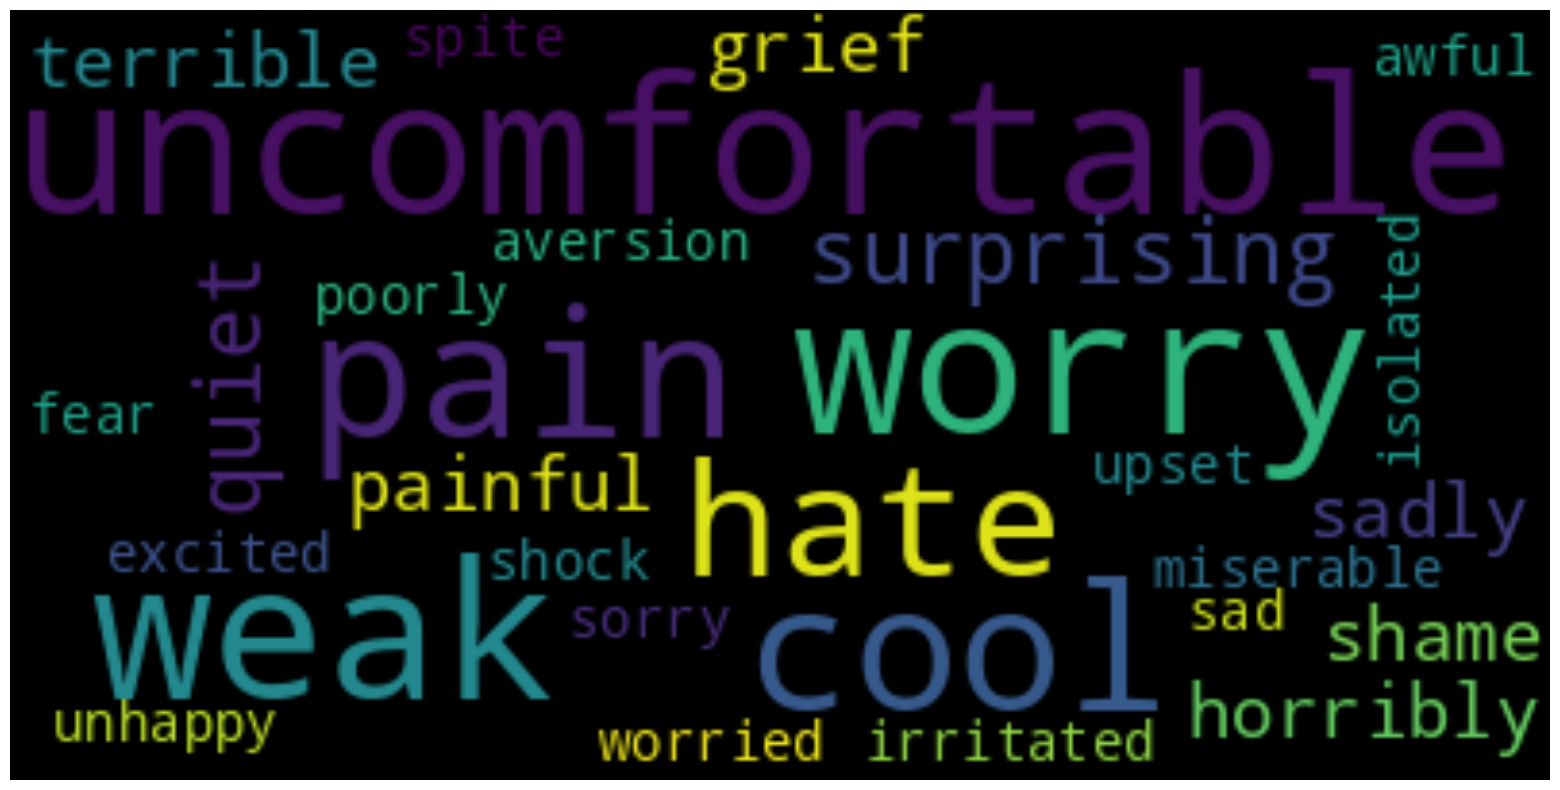

In [ ]:
# Performing ABSA
# Doing only for galaxy s3
for topic in topics:
    if topic == 'galaxy s3':
        print(topic)
        # Getting DataFrame which has the topic in them
        df_device = df[df['preprocessed review'].str.contains(topic,case=False)]
        df_device.reset_index(inplace=True)
        df_device.drop('index',axis=1,inplace=True)

        # Try to load for device if present
        vectorizer = load_work(lda_device_path,device = topic + "_lda_vectorizer")
        vectorised = load_work(lda_device_path,device = topic + "_lda_vectorised")
        lda_model = load_work(lda_device_path,device = topic + "_lda_model")
        lda_output = load_work(lda_device_path,device = topic + "_lda_output")

        # if not present then find using lda
        if type(vectorizer) is not bool:
            if (not lda_output.any()) and (not lda_model.any()) and (not vectorizer.any()) and (not vectorised.any()):
                vectorizer,vectorised,lda_model,lda_output = get_LDA_Model(topic,df_device)
                _ = save_work(lda_device_path,vectorizer,device = topic + "_lda_vectorizer")
                _ = save_work(lda_device_path,vectorised,device = topic + "_lda_vectorised")
                _ = save_work(lda_device_path,lda_model,device = topic + "_lda_model")
                _ = save_work(lda_device_path,lda_output,device = topic + "_lda_output")
        else:
            if (not lda_output) and (not lda_model) and (not vectorizer) and (not vectorised):
                vectorizer,vectorised,lda_model,lda_output = get_LDA_Model(topic,df_device)
                _ = save_work(lda_device_path,vectorizer,device = topic + "_lda_vectorizer")
                _ = save_work(lda_device_path,vectorised,device = topic + "_lda_vectorised")
                _ = save_work(lda_device_path,lda_model,device = topic + "_lda_model")
                _ = save_work(lda_device_path,lda_output,device = topic + "_lda_output")

        df_device = get_lda_aspects(df_device,lda_model,lda_output)
        tmp = get_lda_aspects_scores(df_device,lda_model,vectorizer,lda_output)
        all_aspects = get_dominant_topics(tmp)
        all_aspects
        num_topics = all_aspects.shape[0]
        graph_res,graph_img = analyse_results(df_device,all_aspects)
        graph_img
        # Plot graph here(also save it)
        show_and_save_plot(graph_img,img_device_path,topic)

        # will do this for all topics we got(also check dataframe)
        for i in range(1,num_topics+1):

            positive_words,negative_words,unique_positive_words,unique_negative_words = get_sentiment_words(df_device,i)
            positive_words, negative_words = count_words_scores(positive_words,negative_words,unique_positive_words,unique_negative_words)

            save_wordcloud(positive_words,os.path.join(img_device_path,topic + "_aspect_num_" + f"{i}" + "_positive_word_cloud"))
            save_wordcloud(negative_words,os.path.join(img_device_path,topic + "_aspect_num_" + f"{i}" + "_negative_word_cloud"))

## calculating f1 score, precision and recall


In [ ]:
for topic in topics:
        df_device = df[df['preprocessed review'].str.contains(topic,case=False)]
        df_device.reset_index(inplace=True)
        df_device.drop('index',axis=1,inplace=True)
        # df_device
        y_true = df_device['summary sentiment'].tolist()
        y_pred = df_device['sentiment'].tolist()
        # calculate F1 score
        f1 = f1_score(y_true, y_pred, average='weighted')

        # calculate precision
        precision = precision_score(y_true, y_pred, average='weighted')

        # calculate recall
        recall = recall_score(y_true, y_pred, average='weighted')
        # print results
        print(f"Device: {topic}")
        print(f"F1 score: {f1:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")

<ipython-input-10-bc61c0a36b11>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_device.drop('index',axis=1,inplace=True)


Device: galaxy note
F1 score: 0.52
Precision: 0.56
Recall: 0.61


<ipython-input-10-bc61c0a36b11>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_device.drop('index',axis=1,inplace=True)


Device: galaxy s3
F1 score: 0.55
Precision: 0.58
Recall: 0.64


<ipython-input-10-bc61c0a36b11>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_device.drop('index',axis=1,inplace=True)


Device: iPad
F1 score: 0.52
Precision: 0.55
Recall: 0.62


<ipython-input-10-bc61c0a36b11>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_device.drop('index',axis=1,inplace=True)


Device: iPhone
F1 score: 0.55
Precision: 0.58
Recall: 0.64
